### Using BERTopic for topic classification

In [1]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch import _utils

2023-05-24 17:14:37.596418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 17:14:44.162346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-24 17:14:44.163967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [4]:
import os
os.environ["TOKENIZERS _PARALLELISM"] = "true"

In [ ]:
!pip install -q torch==1.12.0 
!pip install bertopic

In [5]:
import pandas as pd

In [6]:
%%time

df_processed = pd.read_parquet('06_sent_trans_df.parquet', engine='pyarrow')
df_processed.shape

CPU times: user 1min 6s, sys: 12.4 s, total: 1min 19s
Wall time: 1min 24s


(198564, 10)

In [7]:

# Convert the 'year_month' column to datetime format
df_processed['formatted_date'] = pd.to_datetime(df_processed['year_month'].astype(str) + '-01').dt.to_period('M').dt.to_timestamp()

# Use the 'dt' accessor to extract the month and year, and format it as "Jan 2019"
df_processed['year_month'] = df_processed['year_month'].dt.strftime('%b %Y')


In [8]:
df_pos = df_processed[df_processed['sentiment_label'] == 'positive']
df_neg = df_processed[df_processed['sentiment_label'] == 'negative']

In [23]:
len(documents_neg)

4410

In [10]:
documents_pos = df_pos['clean_text_sent'].tolist()
documents_neg = df_neg['clean_text_sent'].tolist()


In [66]:
%%time
from tqdm import tqdm

topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
#topic_model = BERTopic(calculate_probabilities=True, verbose=True)
# Use tqdm to track progress
with tqdm(total=len(documents_pos), desc="Fitting BERTopic") as pbar:
    topics = topic_model.fit_transform(documents_pos)
    pbar.update(len(documents_pos))

# Access the probabilities separately
probs = topic_model.transform(documents_pos)


Fitting BERTopic:   0%|          | 0/30254 [00:00<?, ?it/s]

Batches:   0%|          | 0/946 [00:00<?, ?it/s]

2023-05-24 07:38:58,280 - BERTopic - Transformed documents to Embeddings
2023-05-24 07:39:16,718 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-24 07:39:26,221 - BERTopic - Clustered reduced embeddings
Fitting BERTopic: 100%|██████████| 30254/30254 [13:11<00:00, 38.23it/s]


Batches:   0%|          | 0/946 [00:00<?, ?it/s]

2023-05-24 07:53:59,580 - BERTopic - Reduced dimensionality
2023-05-24 07:54:15,073 - BERTopic - Calculated probabilities with HDBSCAN
2023-05-24 07:54:15,074 - BERTopic - Predicted clusters


CPU times: user 3h 34min 36s, sys: 32min 42s, total: 4h 7min 19s
Wall time: 25min 43s


In [69]:
# Save the model to a file
topic_model.save("bert_pos.pkl")

# Load the model from the saved file
loaded_model_pos = BERTopic.load("bert_pos.pkl")

In [ ]:
%%time

topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(documents_pos)


In [ ]:
##topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
##topics, probs = topic_model.fit_transform(documents)

In [70]:
freq = loaded_model_pos.get_topic_info()

print(f"Topics found: {freq.shape[0]}")

Topics found: 46


CPU times: user 16.6 s, sys: 5.08 s, total: 21.6 s
Wall time: 21.5 s


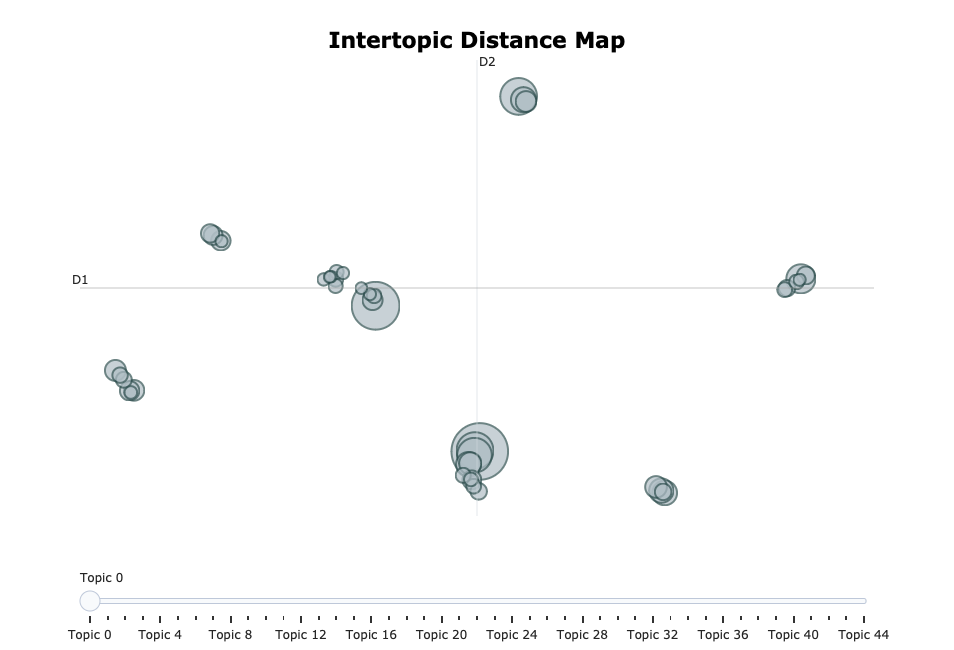

In [71]:
%%time

loaded_model_pos.visualize_topics()

In [72]:
freq.head(10)

,Topic,Count,Name
0,-1,13759,-1_ai_market_data_technology
1,0,2405,0_market_report_analysis_global
2,1,1712,1_ai_gray_group_media group
3,2,1023,2_healthcare_market_intelligence_artificial in...
4,3,1011,3_products_entertainment_services_resources
5,4,899,4_market_intelligence_artificial_artificial in...
6,5,633,5_ai_customer_business_data
7,6,472,6_und_zu_die_sie
8,7,460,7_machine learning_learning_machine_market
9,8,457,8_us_newswires_new_south


In [83]:
topics, probs = topic_model.topics_, topic_model.probabilities_

In [89]:
#removing outliers
df_pos_topic = df_pos[df_pos['bert_topic'] != -1]
df_pos_topic.shape[0]

16495

In [88]:
df_pos['bert_topic'] = topics

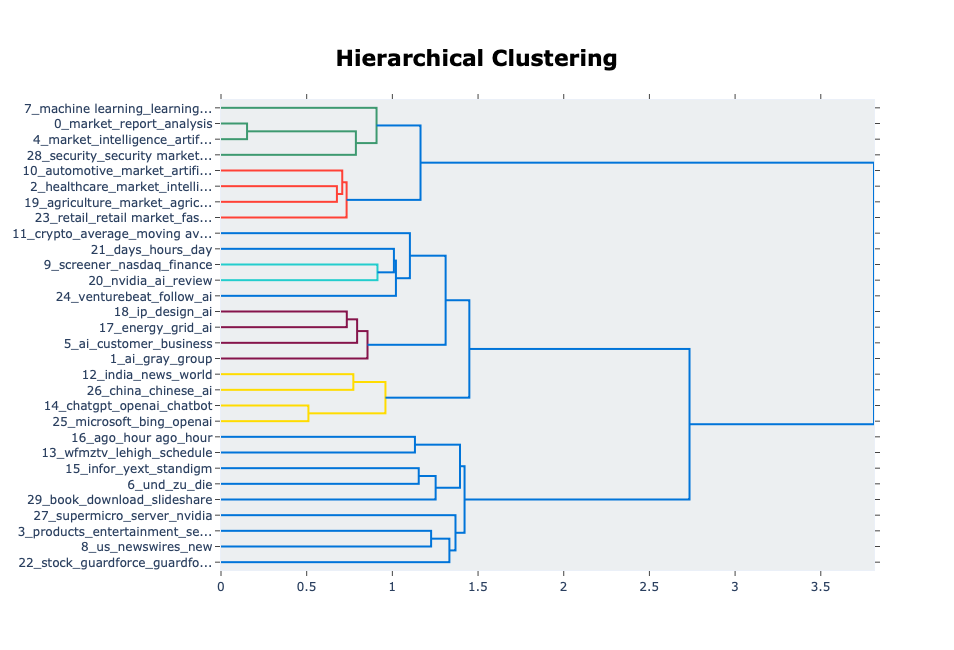

In [91]:
loaded_model_pos.visualize_hierarchy(top_n_topics=30)

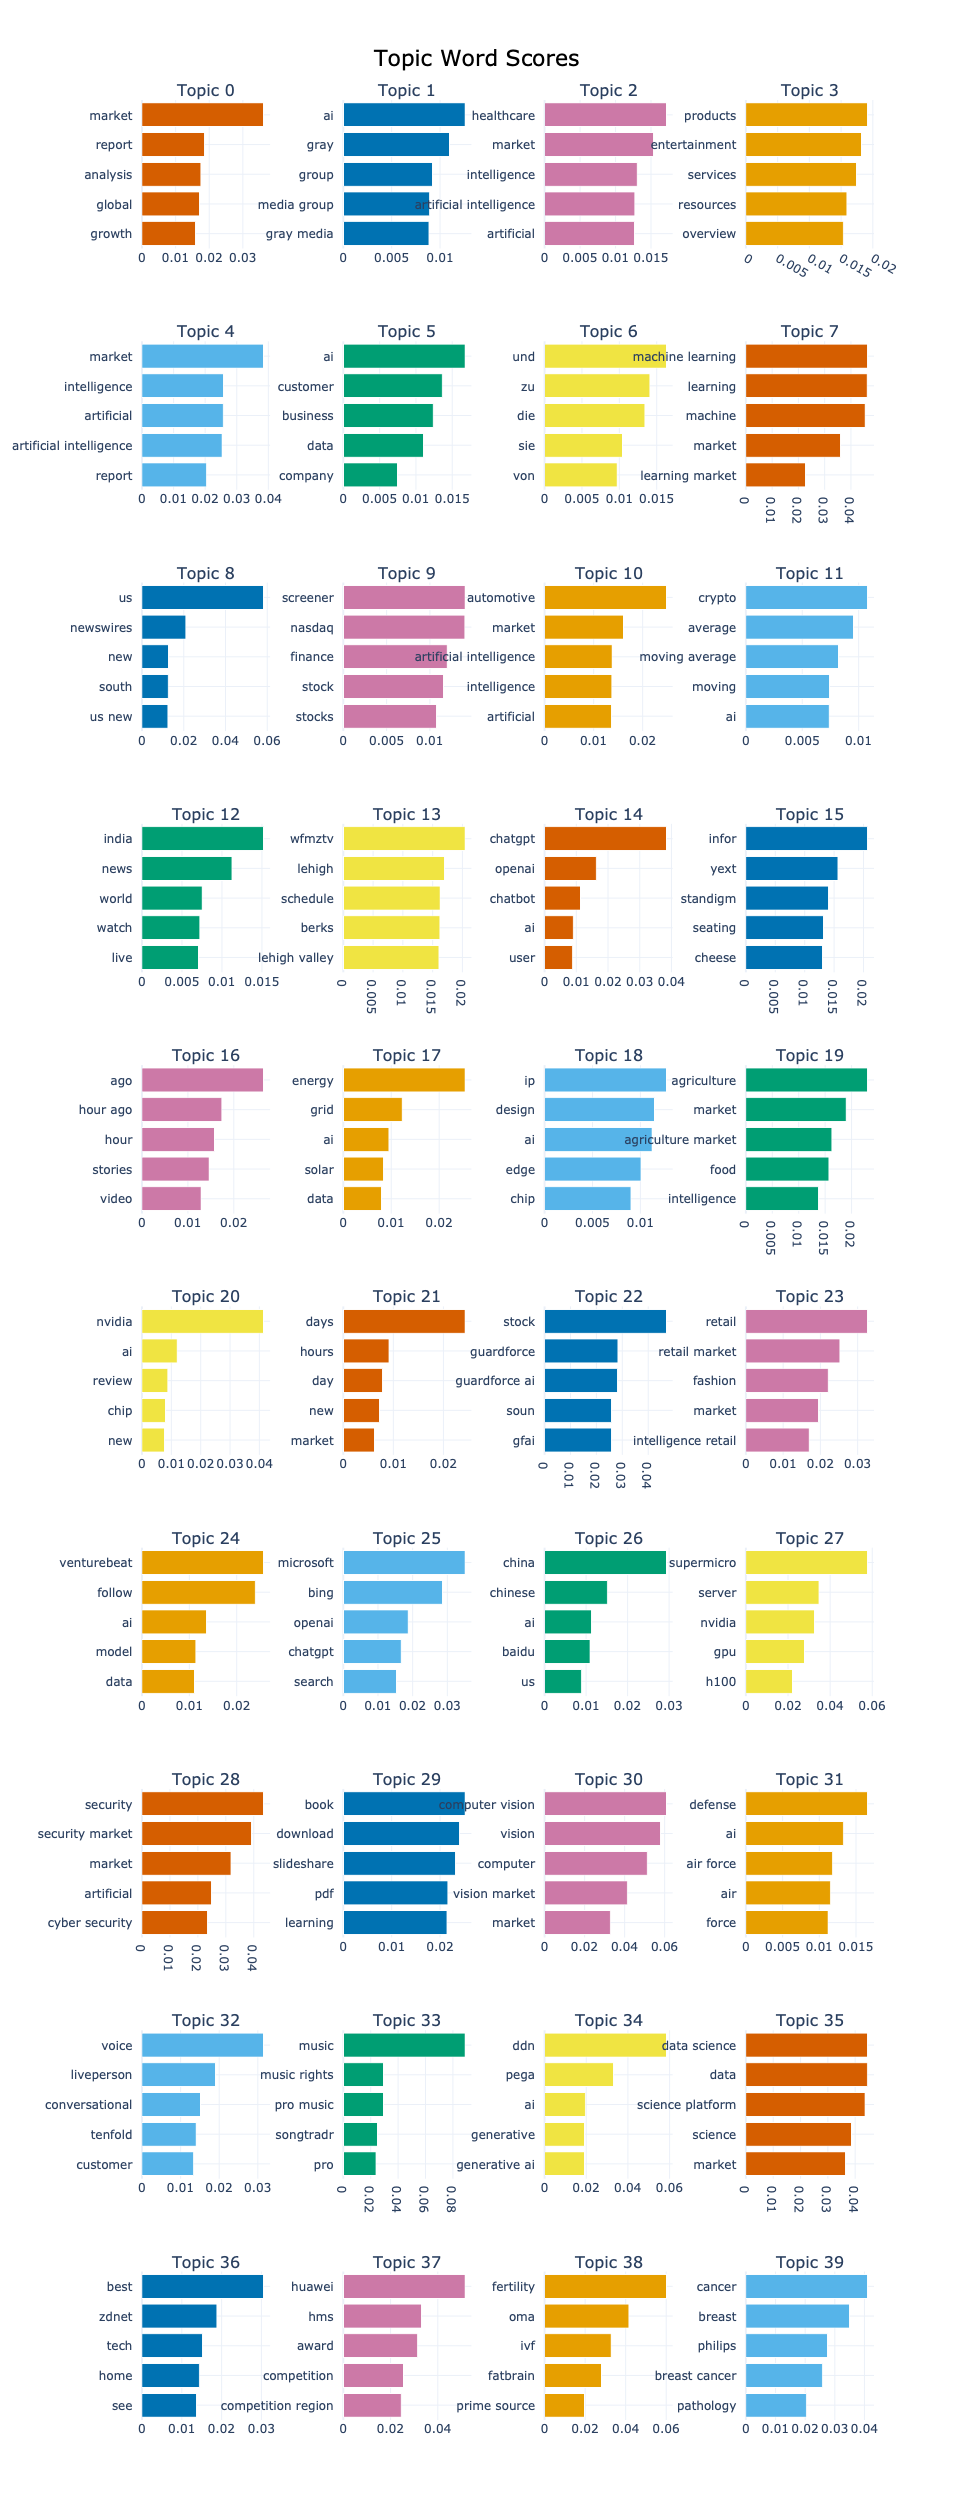

In [95]:
topic_model.visualize_barchart(top_n_topics=40)

In [24]:
%%time
from tqdm import tqdm

topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
#topic_model = BERTopic(calculate_probabilities=True, verbose=True)
# Use tqdm to track progress
with tqdm(total=len(documents_neg), desc="Fitting BERTopic") as pbar:
    topics = topic_model.fit_transform(documents_neg)
    pbar.update(len(documents_neg))

# Access the probabilities separately
probs = topic_model.transform(documents_neg)


Fitting BERTopic:   0%|          | 0/4410 [00:00<?, ?it/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

2023-05-24 17:43:58,766 - BERTopic - Transformed documents to Embeddings
2023-05-24 17:44:06,694 - BERTopic - Reduced dimensionality
2023-05-24 17:44:07,169 - BERTopic - Clustered reduced embeddings
Fitting BERTopic: 100%|██████████| 4410/4410 [02:15<00:00, 32.54it/s]


Batches:   0%|          | 0/138 [00:00<?, ?it/s]

2023-05-24 17:46:22,435 - BERTopic - Reduced dimensionality
2023-05-24 17:46:23,550 - BERTopic - Calculated probabilities with HDBSCAN
2023-05-24 17:46:23,551 - BERTopic - Predicted clusters


CPU times: user 36min 22s, sys: 6min 57s, total: 43min 19s
Wall time: 4min 12s


In [25]:
# Save the model to a file
topic_model.save("bert_neg.pkl")

# Load the model from the saved file
loaded_model_neg = BERTopic.load("bert_neg.pkl")

In [26]:
freq = loaded_model_neg.get_topic_info()

print(f"Topics found: {freq.shape[0]}")

Topics found: 5


CPU times: user 1.2 s, sys: 13.9 ms, total: 1.21 s
Wall time: 962 ms


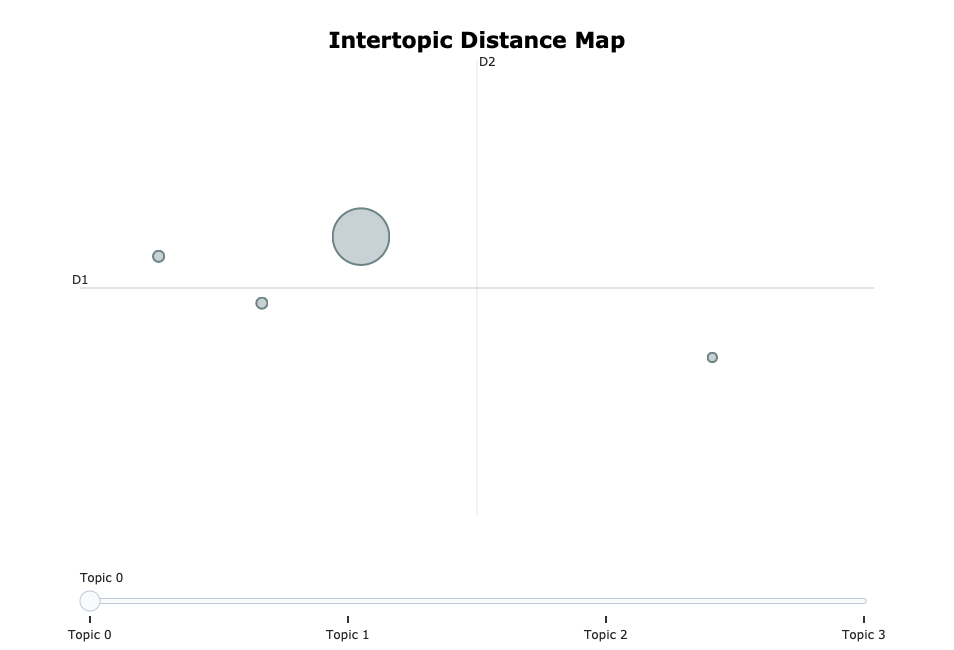

In [27]:
%%time

loaded_model_neg.visualize_topics()

In [28]:
freq.head(10)

,Topic,Count,Name
0,-1,338,-1_ai_link machine_dollar_traded
1,0,3690,0_ai_news_company_new
2,1,141,1_lisk machine_lisk_machine learning_machine
3,2,140,2_decentralized_decentralized machine_machine ...
4,3,101,3_matrix_ai network_matrix ai_network


In [29]:
topics, probs = topic_model.topics_, topic_model.probabilities_

In [30]:
len(topics)

4410

In [31]:
df_neg['bert_topic'] = topics

In [32]:
#removing outliers
df_neg_topic = df_neg[df_neg['bert_topic'] != -1]
df_neg_topic.shape[0]

4072

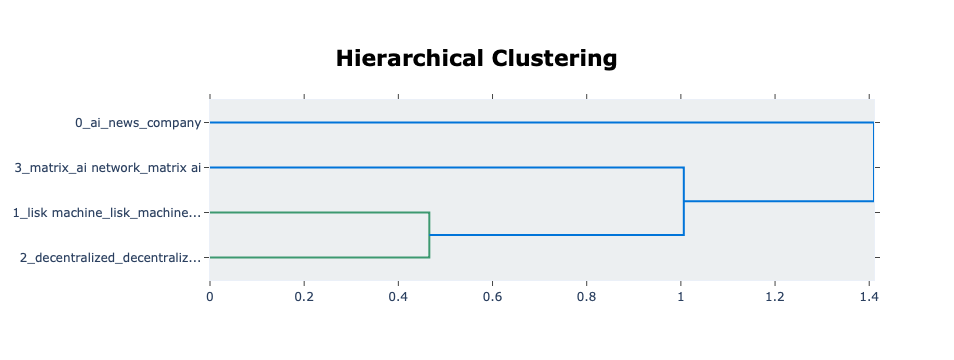

In [34]:
loaded_model_neg.visualize_hierarchy(top_n_topics=30)

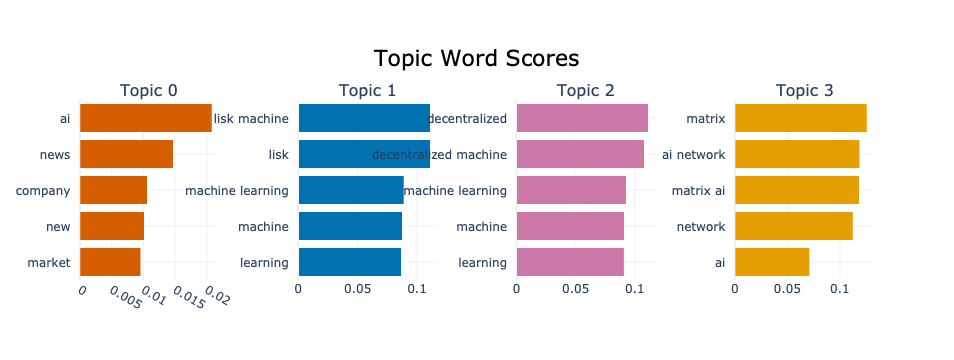

In [35]:
loaded_model_neg.visualize_barchart(top_n_topics=40)